# Extração de Texto

In [1]:
from skimage import io, morphology, filters, color, transform, measure
from glob import glob

original = []
for image in glob('*.png'):
    original.append(io.imread(image))

Vamos dar uma olhada nas imagens:

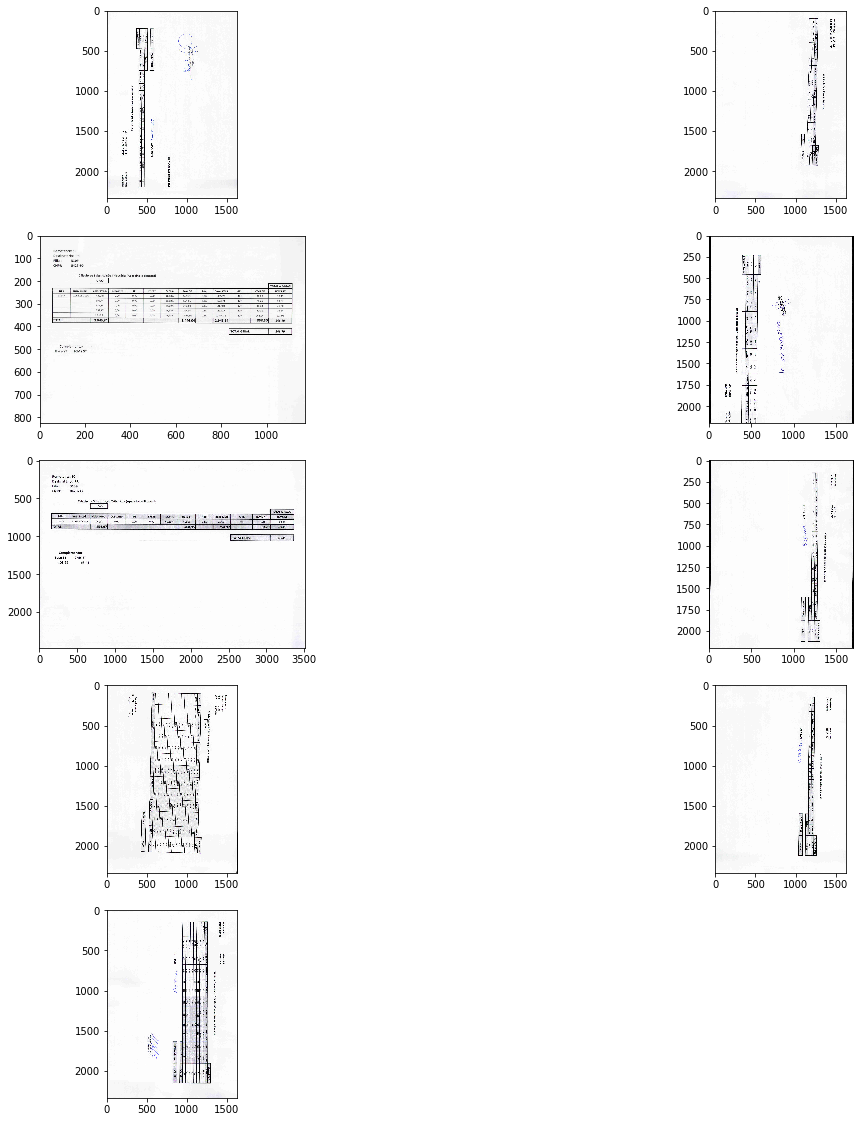

In [4]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20,20))
for i, image in enumerate(original):
    plt.subplot(5,2,1+i)
    plt.imshow(image)
    
plt.show()

## Corrigindo a Rotação
Todas as tabelas estão impressas em landscape mas algumas páginas estão giradas aproximaamente 90, 180 ou 270 graus.
<br>
<br>
O primeiro passo foi detectar as 10 linhas mais longas da imagem e usar a mediana do ângulo para corrigir a rotação. Para detectar se a imagem está girada 180 graus estou usando um algoritmo naif que assume que o canto superior esquerdo é sempre mais escuro que o canto inferior direito

In [12]:
import numpy as np

def thresholded(im):
    im = color.rgb2gray(im)
    im = im > filters.threshold_otsu(im)
    return ~im

def morphed(im, min_area=1024):
    im = thresholded(im)
    k1 = morphology.rectangle(1,40)
    k2 = morphology.rectangle(20,1)
    return morphology.remove_small_objects(morphology.binary_opening(im,k1) |
                                          morphology.binary_opening(im,k2), min_area)

def line_angle(line):
    (x1,y1), (x2,y2) = sorted(line)
    radians = np.arctan2(y2-y1,x2-x1)
    return np.rad2deg(radians)

def deskewed(im):
    h,w = im.shape[:2]
    if h > w:
        im = transform.rotate(im, -90, True)
        
    # upper left is lighter than lower right
    if np.mean(im[:h//4,:w//4]) > np.mean(im[h//4:, w//4:]):
        im = transform.rotate(im, 180, True)
        
    lines = transform.probabilistic_hough_line(
        morphed(im[100:-100, 100:-100]),
        threshold=10,
        line_length=max(im.shape)//4,
        line_gap=10
    )
    
    lines = sorted(lines, key=lambda x: abs(x[0][0] - x[1][0]),
                  reverse=True)[:10]
    
    angle = np.median([line_angle(line) for line in lines])
    
    if angle > 0.1:
        return transform.rotate(im, angle, cval=1)
    
    return im

Nesse ponto as imagens devem estar com a rotação corrigida:

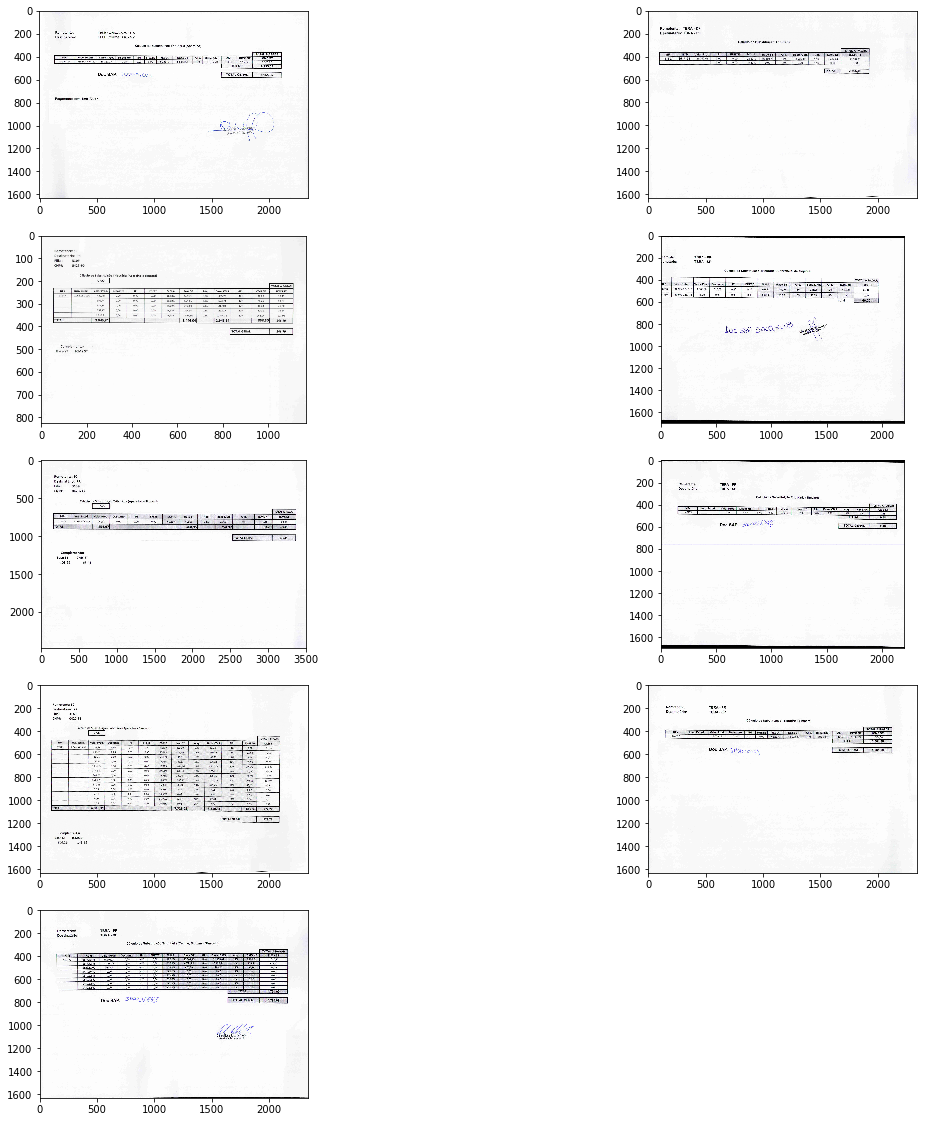

In [14]:
images = [deskewed(im) for im in original]
fig = plt.figure(figsize=(20,20))
for i, image in enumerate(images):
    plt.subplot(5,2,1+i)
    plt.imshow(image)
    
plt.show()